In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib
import MegaScreen
import numpy as np
import scipy.integrate
from test_Noll import Noll
from test_spectrum import interf_spectrum_quad as interf_spectrum
import functools
from MegaScreen import VonKarmanSpectrum, NestedSpectra

%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 200
matplotlib.rcParams['text.usetex'] = False

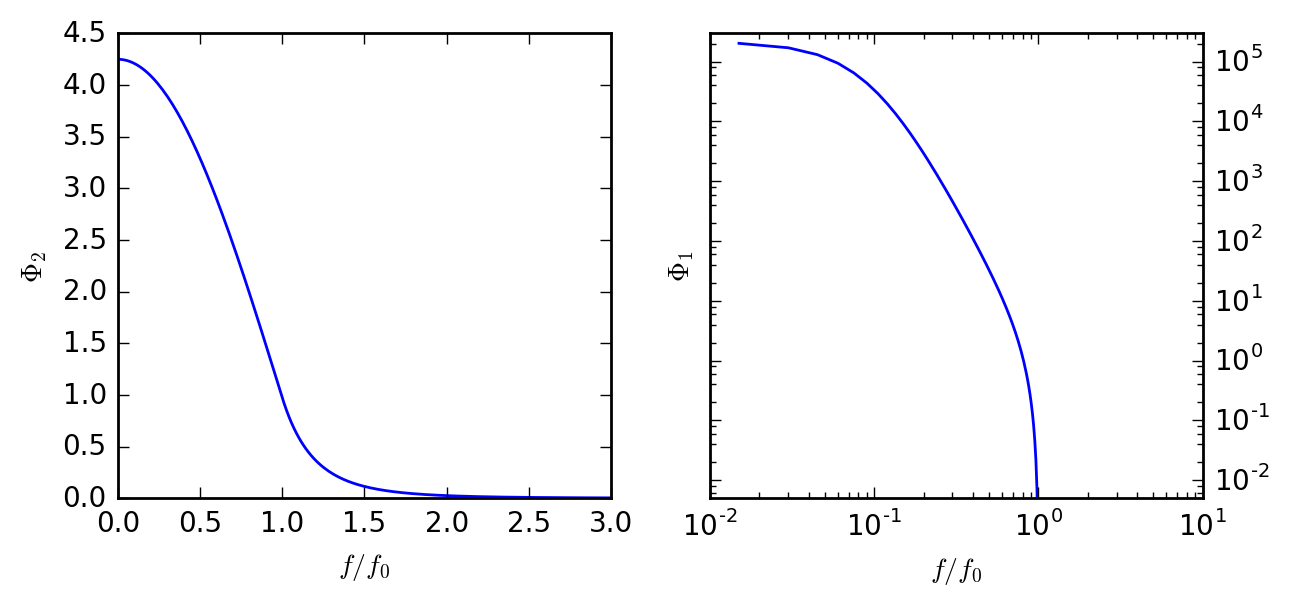

In [2]:
def spectrum(f):
    return (f**2+0.1**2)**(-8/3)
inner,outer=NestedSpectra(spectrum,f0=1)

plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
f=np.linspace(0,3,200)
plt.plot(f,outer(f))
plt.xlabel("$f/f_0$")
plt.ylabel(r"$\Phi_2$")
#plt.title("Tweeter")
plt.subplot(1,2,2)
plt.loglog(f[:-1],inner(f)[:-1])
#plt.title("Woofer")
plt.xlabel("$f/f_0$")
plt.ylabel(r"$\Phi_1$")
plt.ylim(5e-3,3e5)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='on',      # ticks along the bottom edge are off
    right='on',         # ticks along the top edge are off
    labelright="on",
    labelleft="off"
    )
matplotlib.rcParams['text.usetex'] = False
plt.savefig("tweetwoof.eps",bbox_inches="tight")

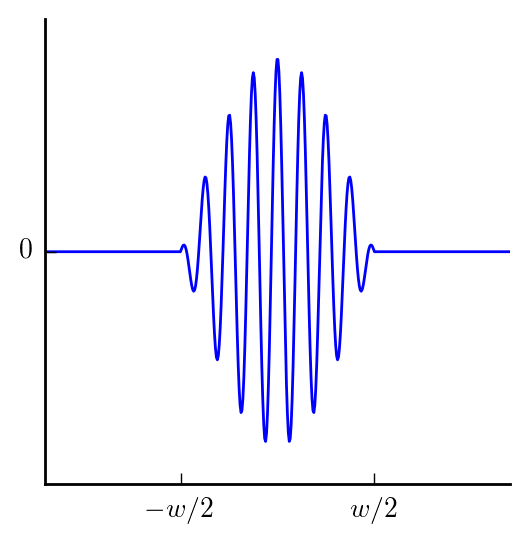

In [5]:
def CosHat(x,w=1):
    y=np.cos(np.pi*x/(w))
    y[np.abs(x)>w/2]=0.0
    return y

def AmplitudeSpectrum(data):
    return np.fft.fftshift(abs(np.fft.fft(data)))

def FftCoords(xmax,nfft):
    deltax=xmax/nfft
    deltaf=1.0/xmax
    x=np.arange(nfft)*deltax    
    f=np.fft.fftfreq(nfft,deltax)
    return x,np.fft.fftshift(f)

def NewCoords(oversampling,nfft):
    x=np.linspace(-oversampling,oversampling,nfft)
    deltax=x[1]-x[0]
    f=np.fft.fftfreq(nfft,deltax)
    return x,np.fft.fftshift(f)

def fftpartialshift(f,a,fshift):
    nfft=len(f)
    deltaf=f[1]-f[0]
    nshift=int(fshift/deltaf)
    indices=(np.arange(nfft)-nshift)%nfft
    return a[indices]

# Specialised for shifted FFTs
def PlotRange(x,y,xmax,normalise=True):
    deltax=x[1]-x[0]
    indices=(abs(x)<xmax)
    if normalise:
        norm=y[x==0]
    else:
        norm=1.0
    plt.plot(x[indices],y[indices]/norm)

def PlotRange2(x,y,xmax):
    deltax=x[1]
    numPlot=int(xmax/deltax)
    plot(x[:numPlot],y[:numPlot])

x,f=NewCoords(5,2048)

def packet(x,f0):
    return np.cos(2*np.pi*f0*x)*CosHat(x)
y=packet(x,8)

plt.figure(figsize=(3,3))
plt.plot(x,y)
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.xticks([-0.5,0.5],["$-w/2$","$w/2$"])
plt.yticks([0])
ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
#ax.spines['bottom'].set_position(('data',0))
ax.yaxis.set_ticks_position('left')
#ax.spines['left'].set_position(('data',0))
matplotlib.rcParams['text.usetex'] = True
plt.savefig("packet.eps",bbox_inches="tight")

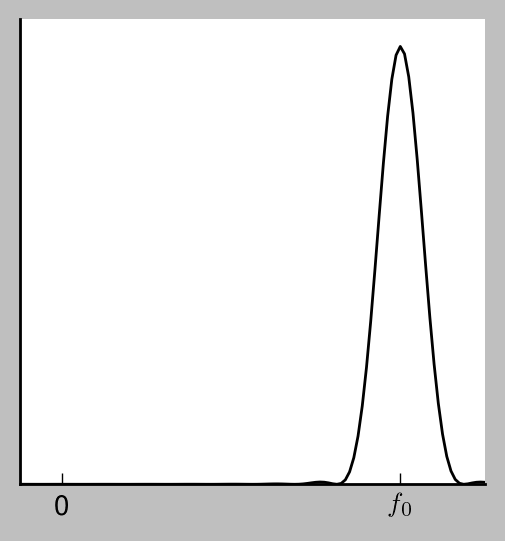

In [7]:
plt.figure(figsize=(3,3))
plt.style.use("grayscale")
p=AmplitudeSpectrum(y)**2
plt.plot(f,p)
plt.xlim(-1,10)
plt.yticks([])
plt.xticks([0,8],["0","$f_0$"])
ax=plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    top='off',      # ticks along the bottom edge are off
    bottom='on',         # ticks along the top edge are off
    )

plt.savefig("one_peak.eps",bbox_inches="tight")

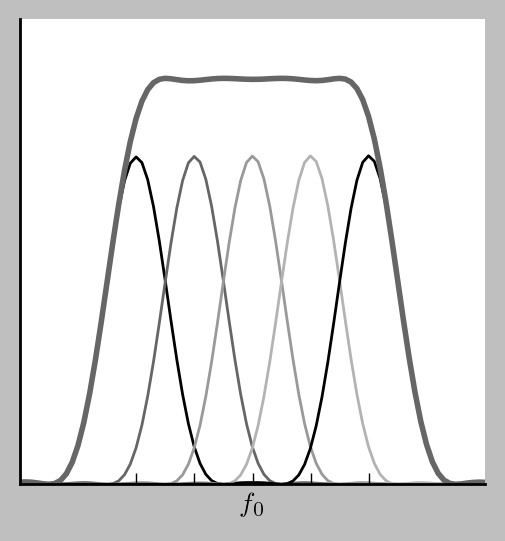

In [10]:
plt.figure(figsize=(3,3))
plt.style.use("grayscale")
spectra=np.array([AmplitudeSpectrum(packet(x,f0))**2 for f0 in [5,6,7,8,9]])
for spectrum in spectra:
    plt.plot(f,spectrum)
plt.xlim(3,11)
plt.plot(f,np.sum(spectra,axis=0),lw=2)
plt.yticks([])
plt.xticks([5,6,7,8,9],[r"","",r"$f_0$","",""])
ax=plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    top='off',      # ticks along the bottom edge are off
    bottom='on',         # ticks along the top edge are off
    )

#plt.grid()
plt.savefig("smoothpeaks.eps",bbox_inches="tight")

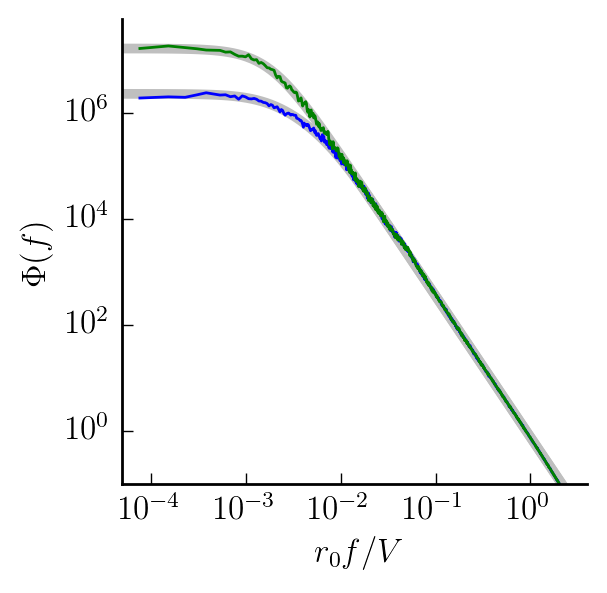

In [2]:
def logbin(x,y,unitbin):
    """
    C UNITBIN is the x-coord at which the bin size is equal to the initial
    C bin size. For samples up to this ordinate, no binning is done, and
    C after this the bin size is the nearest integer to X/UNITBIN where X is
    C the x-coord of the  leftmost initial bin.
    C
    C If last bin has less than a full complement of samples, it IS computed.
    C The number of computed bins is returned in NBIN.
    """
    i=0
    imax=len(x)
    xnew=[]
    ynew=[]
    while i<imax:
        nbin=int(max(1,x[i]/unitbin))
        nbin=min(imax-i,nbin)
        #print(nbin)
        xnew.append(np.sum(x[i:i+nbin])/nbin)
        ynew.append(np.sum(y[i:i+nbin])/nbin)
        i+=nbin
    return np.array(xnew),np.array(ynew)

def PlotSpectrum(filename,unitbin=2e-3):
    i=Table.read(filename,format="ascii.ecsv")
    x,y=logbin(i["frequency"][:-1],i["power"][:-1],unitbin)
    r0=i.meta["r0"]
    plt.loglog(x*r0,y)
    return i

def PlotTheoretical(filename,fmin=1e-5,fmax=1,numpoint=100):
    f=np.logspace(np.log10(fmin),np.log10(fmax),numpoint)
    meta=Table.read(filename,format="ascii.ecsv").meta
    baseline=meta["baseline"]
    r0=meta["r0"]
    L0=meta["L0"]
    plt.plot(f*r0,interf_spectrum(baseline,f,r0=r0,L0=L0),lw=3.5,color="0.75")



plt.figure(figsize=(3,3))
plt.style.use("default")
matplotlib.rcParams['savefig.dpi'] = 200
PlotTheoretical("data/interf_spec160731-1225.dat")
PlotTheoretical("data/interf_spec160731-1204.dat")
PlotSpectrum("data/interf_spec160731-1225.dat",unitbin=2e-3)
PlotSpectrum("data/interf_spec160731-1204.dat",unitbin=2e-3)
plt.ylabel(r"$\Phi(f)$")
plt.xlabel("$r_0f/V$")
plt.ylim(1e-1,6e7)
plt.xlim(5e-5,4)
plt.yticks([1e0,1e2,1e4,1e6])
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    )
#plt.grid()
ax=plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    top='off',      # ticks along the bottom edge are off
    bottom='on',         # ticks along the top edge are off
    )
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    top='off',      # ticks along the bottom edge are off
    bottom='off',         # ticks along the top edge are off
    )

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    left='on',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    )

matplotlib.rcParams['text.usetex'] = True
plt.savefig("interf_spectrum.eps",bbox_inches="tight")

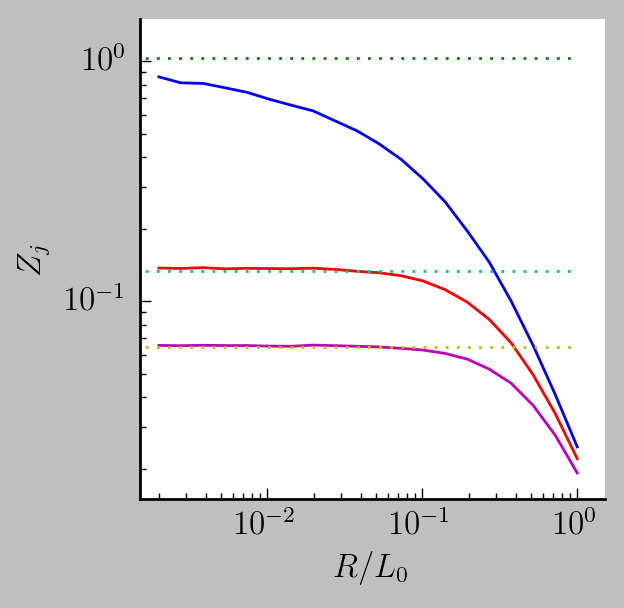

In [3]:
def PlotWinker(filename,fmin=1e-3,fmax=1e0):
    t=Table.read(filename,format="ascii.ecsv")
    d=t.meta["diameter"]
    L0=2*t["L0"]/d
    for z in [0,2,5]:
        plt.loglog(1/L0,t["Z"+str(z)],label="Z"+str(z))
        plt.loglog([fmin,fmax],[Noll[z],Noll[z]],ls="dotted")

plt.figure(figsize=(3,3))
PlotWinker("data/winker160731-1558.dat")
plt.ylim(1.5e-2,1.5)
plt.xlim(1.5e-3,1.5)
plt.xlabel(r"$R/L_0$")
plt.ylabel("$Z_j$")
ax=plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    top='off',      # ticks along the bottom edge are off
    bottom='on',         # ticks along the top edge are off
    )
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='on',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    )

#plt.legend()
matplotlib.rcParams['text.usetex'] = True
plt.savefig("winker.eps",bbox_inches="tight")